# Difficulty of question

I will in this notebook look into finding the difficutly of a question in an assignment defined by the graded that each grader gave to that question.

Each question have a latent difficuilty called $d_q$. It can also be assumed that the evaluated value $X$ of question $q$ from all graders $q$ is taken from a normal distribution with the expected value being $d_q$ and the variance $\sigma$.

$$X \sim N(d_q, \sigma)$$

with pymc it should be possbile to inferre $d_q$ from the provided evaluation data.

In [153]:
%matplotlib inline
from collections import defaultdict
import pymc as pm
from pymc.Matplot import plot
import numpy as np
from matplotlib import pyplot as plt
import json
from pymongo import MongoClient
import pymongo
from bson.objectid import ObjectId

Mock data to test the model

In [3]:
peergrade_value = np.array([0.2, 0.4, 0.4, 0.2, 0.6, 0.4, 0.4, 0, 1, 1, 1])
print peergrade_value.mean()

0.509090909091


We know that the evaluated value of a question to a handin from a grader is an descret value ${val_{min},val_{max}}$. The difficulty of the question $d_q$ must then be a continues value $[val_min,val_max]$.

$$d_q \sim Uniform(val_{min},val_{max})$$

We don't know the value of the variance $\sigma$ yet but it is a real positive value so we can use the exponential distribution to define this. This distribution is defined by the value $alpha$ which is also a real positive number we don't know but we can quess that it is between [0,5]. this can also be defined by the uniform distribution

$$\alpha \sim Uniform(val_{min},val_{max})$$

$$\sigma \sim Exp(\alpha)$$

With the model completed it should be possible to inferre the difficulty of a question in pymc

In [184]:
def difficulty_model(data):
    d_q = pm.Uniform("d_q", 0, 1)
    alpha = pm.Uniform("alpha", 0.1, 5)
    tau = pm.Exponential("tau", alpha)

    graded = pm.Normal("graded", mu=d_q, tau=tau, observed=True,
                       value=data)
    model = pm.Model([graded, tau, alpha, d_q])
    map_ = pm.MAP(model)
    map_.fit()
    mcmc = pm.MCMC(model)
    mcmc.sample(20000, 5000)
    return mcmc

 [-----------------100%-----------------] 20000 of 20000 complete in 4.3 sec
tau:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	6.171            2.964            0.093          [  1.285  12.049]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	1.774            3.971           5.734          7.846         13.153
	

d_q:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.507            0.136            0.003            [ 0.217  0.769]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.233            0.419           0.509          0.593         0.789
	

alpha:
 
	Mean            

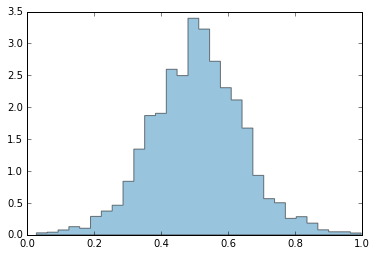

In [154]:
mcmc = difficulty_model(peergrade_value)
mcmc.summary()
p_trace = mcmc.trace("d_q")[:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.5, bins=30,
         label="d_q", color="#348ABD")
plt.show()

We can find the mean value of the $d_q$ and see if it matches the mean value we hvae

In [125]:
np.mean(p_trace)

0.51130461321862775

In [7]:
peergrade_value.mean() 

0.50909090909090904

They are farily close so we can assume that the model is correct

Next we can try out the model on some more real data from a course with multiple data and see if we can find the most and least difficult question.
The data we are looking at contains multiple of different question which have different numerical values of grading.
Some might be simple yes/no answeres if the author did complete a certain task. Other might be discrete numerical answer between [0,3], [0,10]. 
This means that we can't directly compare these without transforming them to be in the same range.

First connect to the mongodb heroku_rnwkcq9r

In [40]:
client = MongoClient()
db = client.heroku_rnwkcq9r

Then find the id for the course computational tools for big data

In [61]:
cursor = db.course.find_one({"short_title": "computational_tools_for_big_data"})
print cursor['_id']

55d9cb9ea6fb8f00080da4a1


Next we want to find the assignment called "UNIX, Python, and Fast Data" 

In [76]:
cursor = db.assignment.find_one({'course': ObjectId("55d9cb9ea6fb8f00080da4a1"), 'title': "UNIX, Python and Fast Data"})
assignment_id = cursor['_id']

In [130]:
print assignment_id

55f277cff3bd61000a2112d4


Go through all handin and all the question and find the relevant 
I first define some helper functions to assist in getting relevant information and normalize the values of the scores

In [108]:
def question_text(question_id):
    question = db.question.find_one({'_id': question_id})
    return question['text']

In [109]:
def question_max_value(question_id):
    question = db.question.find_one({'_id': question_id})
    if question['question_type'] == "boolean":
        return 1
    elif question["question_type"] == "numerical":
        if 'numericalAnswers' in question:
            max_value = max(map(int,question['numericalAnswers'].keys()))
            return max_value
        else:
            return 5

Quick test to see if the functions works

In [121]:
print question_text(ObjectId("55d9cb9ea6fb8f00080da4a2")) == "How well documented is the code?"
print question_max_value(ObjectId("55d9cb9ea6fb8f00080da4a2")) == 5

True
True


In [104]:
def answer_value(answer_id):
    answer = db.answer.find_one({'_id': answer_id})
    q_id = answer['question']
    if 'numerical_answer' in answer:
        return answer['numerical_answer'] / float(question_max_value(q_id))
    elif 'boolean_answer' in answer:
        return answer['boolean_answer'] / float(question_max_value(q_id))

In [112]:
def answer_question_text(answer_id):
    question = db.answer.find_one({'_id': answer_id})
    return question_text(question['question'])

In [119]:
print answer_question_text(ObjectId("55d9cb9ea6fb8f00080da4e8")) == "How well does the solution answer the problem?"
print answer_value(ObjectId("55d9cb9ea6fb8f00080da4e8")) == 0.8

True
True


In [135]:
answer_q = defaultdict(list)

In [136]:
cursor_1 = db.report_grade.find({'assignment': ObjectId('55f277cff3bd61000a2112d4')})
for report_grade in cursor_1:
    cursor_2 = db.answer.find({'report_grade': report_grade['_id']})
    for answer in cursor_2:
        if 'numerical_answer' in answer or 'boolean_answer' in answer:
            answer_q[answer['question']].append(answer_value(answer['_id']))

In [198]:
difficulty_q = dict()
traces = list()

In [229]:
for idx, (question, grading) in enumerate(answer_q.iteritems()):
        mcmc = difficulty_model(grading)
        d_q = mcmc.trace("d_q")[:]
        difficulty_q[idx] = (np.mean(d_q),question,question_text(question))
        traces.append((idx,np.mean(d_q),d_q))

 [-----------------100%-----------------] 20000 of 20000 complete in 4.4 sec

In [223]:
traces.sort(key=lambda x : x[1], reverse=False)

## Plots

We can now plot the prior of the mean value in the Normal distribution of the answer scores.

A high value means that the scores given were high and thereby being an easy question.
A low value means the the scores given where low and thereby the question was hard.

In [225]:
print_name = lambda x : x[2]

24 Were the authors able to cluster the 100,000x100,000 data file? Number of points in largest cluster should be 28470.
15 How good is the solution to Exercise 3.5?
17 How good is the solution to Exercise 1.5?
3 How good is the solution to Exercise 2.2? Remember that using bin() is not allowed.
2 How good is the solution to Exercise 1.1?
14 In Exercise 3.5, did the authors remember to use cdef on the variables to achieve a bigger speedup?
16 Are the authors anynomous?


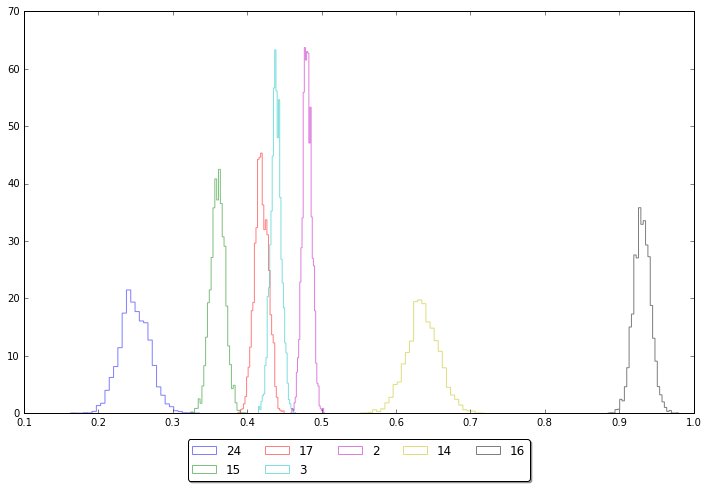

In [227]:
ax = plt.subplot(111)

for (idx,mean,trace) in traces[0::4]:
    print idx, print_name(difficulty_q[idx])
    ax.hist(trace, histtype="step", normed=True, alpha=0.5, bins=30, label=str(idx))

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1 * 2,
                 box.width * 2, box.height * 0.9 * 2])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()